# Project 1 - Regression
## Predict songs popularity
(c) Nuno António 2022 - Rev. 1.0


### 0. Packages,  Libraries and Formating

In [61]:
# Installing the necessary packages:
# Packages
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model
from sklearn import metrics
from yellowbrick.model_selection import RFECV
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn.preprocessing import MinMaxScaler
import pyarrow

In [62]:
# Formating that will be applied in all of the notebook
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 15
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 12
heatmaps_text_fontSize = 12

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

# increase the number of columns to display
pd.set_option('display.max_columns', 500)

Reading data from the parquet file that we made, that has clean and encoded data

In [63]:
# Loading the dataset: 
ds = pd.read_parquet('oneHotEncoded.parquet.snappy', engine='fastparquet')
ds.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
song_popularity,14456.0,48.683246,20.340295,0.000000,37.00000,52.00000,63.000000,100.000
song_duration_ms,14456.0,218224.175844,57292.391246,26186.000000,183750.00000,211797.00000,244720.000000,578040.000
acousticness,14456.0,0.270956,0.298345,0.000001,0.02410,0.14100,0.458000,0.996
danceability,14456.0,0.625913,0.157727,0.059400,0.52675,0.63700,0.741000,0.987
energy,14456.0,0.639035,0.221819,0.001070,0.49500,0.67200,0.817000,0.999
instrumentalness,14456.0,0.092116,0.240794,0.000000,0.00000,0.00002,0.004902,0.997
liveness,14456.0,0.180359,0.144928,0.010900,0.09300,0.12100,0.224000,0.986
loudness,14456.0,-7.699483,4.024637,-38.768000,-9.41125,-6.76500,-5.008000,-0.257
speechiness,14456.0,0.099610,0.103485,0.022400,0.03730,0.05420,0.113000,0.941
tempo,14456.0,121.281860,29.054537,46.591000,98.28800,120.02950,139.965000,216.115


## 4. Modeling

The objetive of the model is to predict the song_popularity, so it was used to define the target variable:

In [64]:
# Target column
y = ds['song_popularity']

Since song_popularity is the target variable, it should be removed from the other variables dataset:

In [65]:
X = ds.drop(columns=['song_popularity'])

Considering that the linear regressios requires normalized data, the MinMax scaler should be applied to have the data normalized:

In [66]:
# Normalize training data
scaler = MinMaxScaler(feature_range=(0, 1))

# MinMax scaler returns an array, so the dataframe must be recreated
ds_scaled = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns,index=X.index)

In [67]:
# Split the dataset intro train and test
X_train, X_test, y_train, y_test = train_test_split(ds_scaled, y, train_size = 0.75, test_size = 0.25, random_state = 123)

In [68]:
# Initialize model
lr_regr = linear_model.LinearRegression(n_jobs = -1)

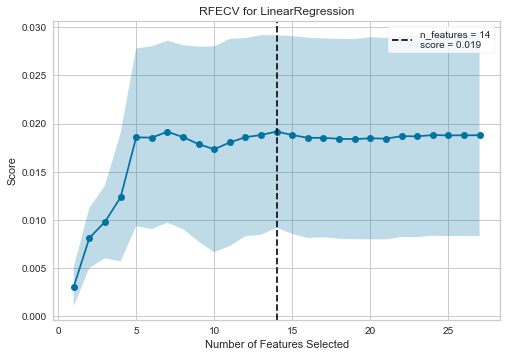

<AxesSubplot:title={'center':'RFECV for LinearRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [69]:
# Apply RFECV (Recursive Feature Elimination) to select features
# see https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html
vis = RFECV(lr_regr, cv=5, scoring='r2')
vis.fit(X_train, y_train)
vis.show()

In [70]:
# Features to include (all in this case)
X.columns[vis.support_]

Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence',
       'key_1', 'key_6', 'key_9', 'time_signature_3', 'time_signature_5'],
      dtype='object')

The result of RFECV recomended the use of the features listed above that would probably bring more accuracy to the model. It ran iterations removing variables until this ideal result was reached. 

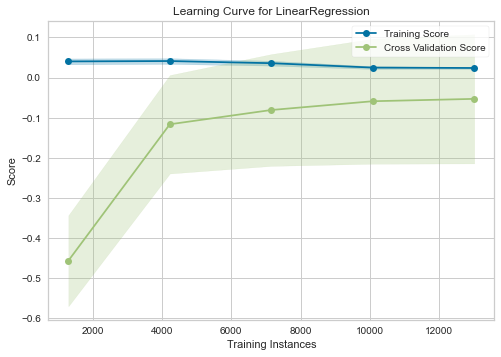

<AxesSubplot:title={'center':'Learning Curve for LinearRegression'}, xlabel='Training Instances', ylabel='Score'>

In [71]:
# Plot the learning curve
cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=lr_regr, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=-1, random_state=123)
visualizer.fit(X[X.columns[vis.support_]], y)
visualizer.show()     

The learning curve shows that the model is possible overfitting, since the training and cross validation score lines are not close.  According to the Yellowbricks documentation, the training score in graph below is much greater than the validation score, then the model probably requires more training examples in order to generalize more effectively.

In [72]:
# Create and train the model
lr_regr.fit(X_train[X.columns[vis.support_]], y_train)

LinearRegression(n_jobs=-1)

In [73]:
# Print the Intercept
print('Intercept:',lr_regr.intercept_, '\n')

# Print Coefficients by descending "importance"
formattedList = [format(float(i),'.6f') for i in lr_regr.coef_]
formattedList2 = [format(abs(float(i)),'.6f') for i in lr_regr.coef_]
data_tuples = list(zip(X.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df['AbsCoefficient']=coeff_df['AbsCoefficient'].astype(float)
coeff_df.sort_values('AbsCoefficient', axis=0, inplace=True, ascending=False)
coeff_df

Intercept: 45.39267892691984 



,Feature,Coefficient,AbsCoefficient
5,liveness,14.935092,14.935092
2,danceability,-8.966796,8.966796
3,energy,-7.056915,7.056915
8,tempo,-6.172667,6.172667
1,acousticness,5.299025,5.299025
4,instrumentalness,-4.031204,4.031204
6,loudness,-3.978007,3.978007
0,song_duration_ms,-2.753201,2.753201
12,key_2,-2.048472,2.048472
10,key_0,2.030046,2.030046


The instrumentalness is the variable that has the greater impact on popularity, followed by song_duration. Those two features have the biggest coefficients, compared to the ones recomended by the RFECV. 

In [74]:
# predict y for X_train and X_test
y_pred_train = lr_regr.predict(X_train[X.columns[vis.support_]]) 
y_pred_test = lr_regr.predict(X_test[X.columns[vis.support_]]) 

In [75]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                metricsObj.mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [76]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,1.589306e+01,1.625317e+01
1,RMSE,2.002321e+01,2.035328e+01
2,R^2,2.520023e-02,1.576338e-02
3,MAPE (%),3.396426e+15,3.601230e+15
4,MAX Error,5.861651e+01,5.432103e+01


The results of the measures shown above of train and test datasets are relatively close to each other, which indicates that train and test datasets have similar characteristics. The split of the data was done effectivelly.

C:\Users\yrama\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


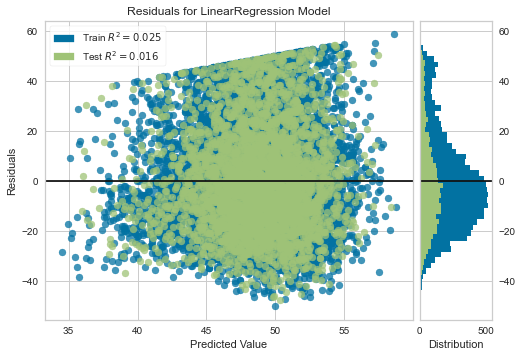

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [77]:
# Visualize the residuals
residuals_vis = ResidualsPlot(lr_regr)
residuals_vis.fit(X_train[X.columns[vis.support_]], y_train)  # Fit the training data to the visualizer
residuals_vis.score(X_test[X.columns[vis.support_]], y_test)  # Evaluate the model on the test data
residuals_vis.show() 

C:\Users\yrama\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


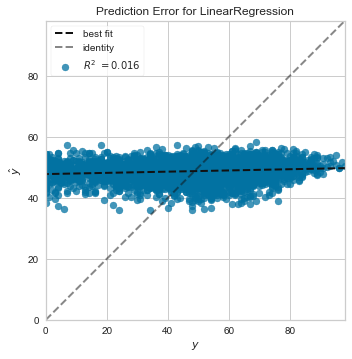

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [79]:
# Visualize the prediction error
predError_vis = PredictionError(lr_regr)
predError_vis.fit(X_train[X.columns[vis.support_]], y_train)  # Fit the training data to the visualizer
predError_vis.score(X_test[X.columns[vis.support_]], y_test)  # Evaluate the model on the test data
predError_vis.show()

## Considerations

- To find the ideal combination of variables to be included in the model in order to reach the best result possible, some tests were made:  
>- 1. using all the features; 
>- 2. using recommended features by the RFECV; 
>- 3. using random columns;
- In the three cases the result was not affected. 

- It was possible to conclude that the results were not as good as expected for having a dataset with low number of registers with high popularity. It would be necessary not only to have more data, but the right data. Searching for effective approaches in similar analysis, it was possible to discover cases in which the artist information was available, the prediction results were more effective, for example. 
